In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

In [2]:
# Basic parameters
Lambda = 0.01
d = 16
h = 1.0/d
Beta = 48
N_samples = 1000
N_steps = 100
T_grid = np.linspace(0,1,N_steps+1)
delta_t = 1.0/N_steps

# Initialization of Ensemble AIS
stretch = 10
inner_iter_AIS = 1
sigma = 1
U_sample = np.random.multivariate_normal(np.zeros(d), sigma*np.identity(d), size = N_samples)

In [3]:
# 1D Ginzburg Landau
def V(U):
    # potential energy V
    if np.size(U.shape) > 1:
        dim1 = U.shape[0]
        U_app = np.concatenate((np.zeros((dim1,1)), U, np.zeros((dim1,1))), axis=1)
        return Beta*(Lambda/h/2 * np.linalg.norm(U_app - np.roll(U_app, 1, axis = 1), axis = 1)**2 + h * np.sum(((1 - U_app**2)**2)[:,1:-1], axis = 1) /4/Lambda)
    else:
        U_app = np.concatenate((np.zeros(1), U, np.zeros(1)), axis=0)
        return Beta*(Lambda/h/2 * np.linalg.norm(U_app - np.roll(U_app, 1, axis = 0), axis = 0)**2 + h * np.sum(((1 - U_app**2)**2)[1:-1], axis = 0) /4/Lambda)


def V_grad(U):
    # Gradient of the potential energy V
    if np.size(U.shape) > 1:
        dim1 = U.shape[0]
        U_app = np.concatenate((np.zeros((dim1,1)), U, np.zeros((dim1,1))), axis=1)
        V_grad_app = Lambda/h * (2*U_app - np.roll(U_app, 1, axis = 1) - np.roll(U_app, -1, axis = 1)) - h * U_app * (1 - U_app**2) /Lambda
        return Beta*V_grad_app[:,1:-1]
    else:
        U_app = np.concatenate((np.zeros(1), U, np.zeros(1)), axis=0)
        V_grad_app = Lambda/h * (2*U_app - np.roll(U_app, 1, axis = 0) - np.roll(U_app, -1, axis = 0)) - h * U_app * (1 - U_app**2) /Lambda
        return Beta*V_grad_app[1:-1]


In [ ]:
for i in range(N_steps):
    print(i)
    print(U_sample[:,3])
    t = (i+1)*delta_t
    gradient = V_grad(U_sample)

    for j in range(N_samples):
        candid = np.delete(np.arange(N_samples), j)

        # MALA Step
        drive = delta_t * (t * gradient[j,:] + (1.0 - t) * (U_sample[j,:] / sigma))
        U_sample_prop = U_sample[j,:] - drive + np.sqrt(2 * delta_t) * np.random.multivariate_normal(np.zeros(d), np.identity(d))
        #print(np.concatenate((np.zeros(1), U_sample_prop, np.zeros(1)), axis=0))
        drive_new = delta_t * (t * V_grad(U_sample_prop) + (1.0 - t) * (U_sample_prop / sigma))

        prob_f = np.power(np.exp(-V(U_sample_prop)), t) * np.power(np.exp(-np.power(np.linalg.norm(U_sample_prop), 2.0) / (2.0 * sigma)), 1.0 - t)
        move_f = np.exp(-np.power(np.linalg.norm(U_sample_prop - U_sample[j,:] + delta_t * drive), 2.0) / (4 * delta_t))
        prob_s = np.power(np.exp(-V(U_sample[j,:])), t) * np.power(np.exp(-np.power(np.linalg.norm(U_sample[j,:]), 2.0) / (2.0 * sigma)), 1.0 - t)
        move_s = np.exp(-np.power(np.linalg.norm(U_sample[j,:] - U_sample_prop + delta_t * drive_new), 2.0) / (4 * delta_t))

        ratio_Q = ((prob_f*move_s) / (prob_s*move_f))
        if ratio_Q > 1.0:
            U_sample[j,:] = U_sample_prop
        elif np.random.uniform(0,1) < ratio_Q:
            U_sample[j,:] = U_sample_prop


        # Snooker Step
        u = np.random.uniform(0, 1)
        z = np.power(u * np.sqrt(stretch) + (1 / np.sqrt(stretch)) * (1.0 - u), 2.0)
        ind = np.random.choice(candid)
        new_point = (1 - z) * U_sample[ind,:] + z * U_sample[j,:]

        prob1 = np.power(np.exp(-V(U_sample_prop)), t)
        prob2 = np.power(np.exp(-V(U_sample[j,:])), t)
        prob3 = np.power(np.exp(-np.power(np.linalg.norm(new_point), 2.0) / (2 * sigma)), 1.0 - t)
        prob4 = np.power(np.exp(-np.power(np.linalg.norm(U_sample[j,:]), 2.0) / (2 * sigma)), 1.0 - t)
        ratio = (z**(d - 1)) * ((prob1 * prob3) / (prob2 * prob4))
        if ratio > 1.0:
           U_sample[j,:] = new_point
           #print("success")
        elif np.random.uniform(0,1) < ratio:
           U_sample[j,:] = new_point
           #print("success")

        # Birth Death Step
        rate = V(U_sample) - (1 / (2*sigma)) * np.power(np.linalg.norm(U_sample, axis = 1), 2.0)
        rate_j = rate[j] - np.average(rate)

        if rate_j > 0:
            prob = 1 - np.exp(-rate_j * delta_t)
            if np.random.uniform(0,1) < prob:
                #print("yeah")
                rand_index = np.random.choice(candid)
                U_sample[j,:] = U_sample[rand_index]

        elif rate_j < 0:
            prob = 1 - np.exp(rate_j * delta_t)
            if np.random.uniform(0,1) < prob:
                #print("yeah")
                rand_index = np.random.choice(candid)
                U_sample[rand_index] = U_sample[j]

0
[-0.0759801   1.12620714 -0.18117581 ...  0.07497856 -0.72302289
  0.99560714]


<ipython-input-4-5970659fcfef>:21: RuntimeWarning: invalid value encountered in scalar divide
  ratio_Q = ((prob_f*move_s) / (prob_s*move_f))
<ipython-input-4-5970659fcfef>:38: RuntimeWarning: invalid value encountered in scalar divide
  ratio = (z**(d - 1)) * ((prob1 * prob3) / (prob2 * prob4))


1
[-0.86726714  1.12620714 -0.18117581 ...  0.07497856 -0.72302289
  0.14985451]
2
[-0.86726714  1.12620714 -0.18117581 ...  0.07497856  0.57721685
  0.14985451]
3
[-0.86726714  1.12620714 -0.18117581 ...  0.07497856  0.57721685
  0.14985451]
4
[-0.86726714  1.12620714 -0.18117581 ...  0.07497856  0.57721685
  0.14985451]
5
[-0.86726714  1.12620714 -0.18117581 ...  0.07497856  0.57721685
  0.14985451]
6
[-0.86726714  1.12620714 -0.18117581 ...  0.07497856  0.57721685
  0.14985451]
7
[-0.86726714  1.12620714 -0.18117581 ...  0.07497856  0.57721685
  0.14985451]
8
[-0.86726714  1.12620714 -0.18117581 ...  0.07497856 -0.91959936
  0.14985451]
9
[-0.86726714  1.12620714 -0.18117581 ...  0.07497856 -0.91959936
  0.14985451]
10
[-0.86726714  1.12620714 -0.18117581 ...  0.07497856 -0.91959936
  0.14985451]
11
[-0.86726714  1.12620714 -0.18117581 ...  0.07497856 -0.91959936
  0.51147113]
12
[-0.86726714  1.12620714 -0.18117581 ...  0.07497856 -0.91959936
  0.51147113]
13
[-0.86726714  1.126207

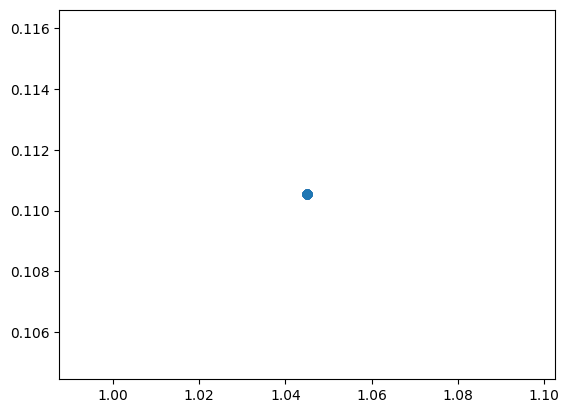

In [146]:
plt.scatter(U_sample[:,1], U_sample[:,3])
#plt.xlim(-2.5, 2.5)
#plt.ylim(-2.5, 2.5)
plt.show()